In [59]:
# TODO
#- Need to validate that all files are being loaded.
#- Dataset is umbalanced, bach has way more entries than the others. consider cleaning for less bias results.
#- Include more descriptive section headers

---

# Composer Classification Using Deep Learning on MIDI Representations

## Introduction

Music is a form of art that is ubiquitous and has a rich history. Different composers have created music with their unique styles and compositions. However, identifying the composer of a particular piece of music can be a challenging task, especially for novice musicians or listeners. The proposed project aims to use deep learning techniques to identify the composer of a given piece of music accurately.

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

## Library Imports

In [4]:
import numpy as np
import pandas as pd
import os
import glob
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Data Collection

In [6]:
target_composers = {'bach', 'beethoven', 'chopin', 'mozart'}

# recursively collect all MIDI files, case-insensitive
midi_files = glob.glob('./dataset/**/*.mid*', recursive=True)
train_data = []

for path in midi_files:
    # normalize path parts
    path_parts = os.path.normpath(path).split(os.sep)

    try:
        # structure: dataset/midiclassics/ComposerName/...
        if 'midiclassics' in path_parts:
            idx = path_parts.index('midiclassics')
            composer = path_parts[idx + 1].lower()  # label (e.g., bach)

            if composer in target_composers:
                midi = pretty_midi.PrettyMIDI(path) # song
                train_data.append((composer, midi))
                
    except Exception as e:
        print(f"Skipped {path}: {e}")

print(f"\nTotal MIDI files loaded: {len(train_data)}")

/opt/anaconda3/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Skipped ./dataset/midiclassics/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Skipped ./dataset/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255

Total MIDI files loaded: 1528


## Feature Extraction
Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

In [8]:
# empty list to store extracted features
data = []

# for each (composer, midi_object) pair in the training dataset
for composer, midi in train_data:
    try:
        duration = midi.get_end_time() # get total duration of the MIDI file in seconds
        tempo = midi.estimate_tempo() # get estimate global tempo (in beats per minute)
        num_notes = sum(len(inst.notes) for inst in midi.instruments) # get total number of notes across all instruments
        num_instruments = len(midi.instruments) # get the number of instrument tracks in the MIDI file

        # lists to collect pitch and timing data for all notes
        pitches = []
        start_times = []
        end_times = []

        # for each instrument and note
        for inst in midi.instruments:
            for note in inst.notes:
                pitches.append(note.pitch) # get pitch number
                start_times.append(note.start) # get start time in seconds
                end_times.append(note.end) # get end time in seconds

        avg_pitch = sum(pitches) / len(pitches) if pitches else 0 # get average pitch (if notes exist)
        
        # get average duration of notes (if notes exist)
        avg_duration = sum(e - s for s, e in zip(start_times, end_times)) / len(start_times) if start_times else 0

        # get number of chords by counting notes that start close together
        chords = 0
        threshold = 0.05  # time difference (in seconds) considered simultaneous
        
        # sort start times to check adjacent notes for closeness
        start_times_sorted = sorted(start_times)
        for i in range(1, len(start_times_sorted)):
            if abs(start_times_sorted[i] - start_times_sorted[i - 1]) <= threshold:
                chords += 1  # consider it part of a chord

        data.append({  # append all the extracted features
            'composer': composer,
            'duration_sec': duration,
            'tempo': tempo,
            'num_notes': num_notes,
            'num_instruments': num_instruments,
            'avg_pitch': avg_pitch,
            'avg_note_duration': avg_duration,
            'estimated_chords': chords
        })

    except Exception as e: # catch and report any errors
        print(f"Error processing MIDI: {e}")

df = pd.DataFrame(data) # convert into a DataFrame
df.head()

,composer,duration_sec,tempo,num_notes,num_instruments,avg_pitch,avg_note_duration,estimated_chords
0,mozart,404.032634,218.736624,7009,8,62.901270,0.305392,5014
1,mozart,361.846184,159.249987,3536,13,61.033654,0.652212,2547
2,mozart,304.218882,229.670316,10671,8,67.302221,0.238669,8488
3,mozart,388.019697,150.909091,4675,19,62.305455,0.724202,3656
4,mozart,626.371366,154.591365,9047,14,66.197082,0.329296,6038


### Exploratory Data Analysis (EDA)

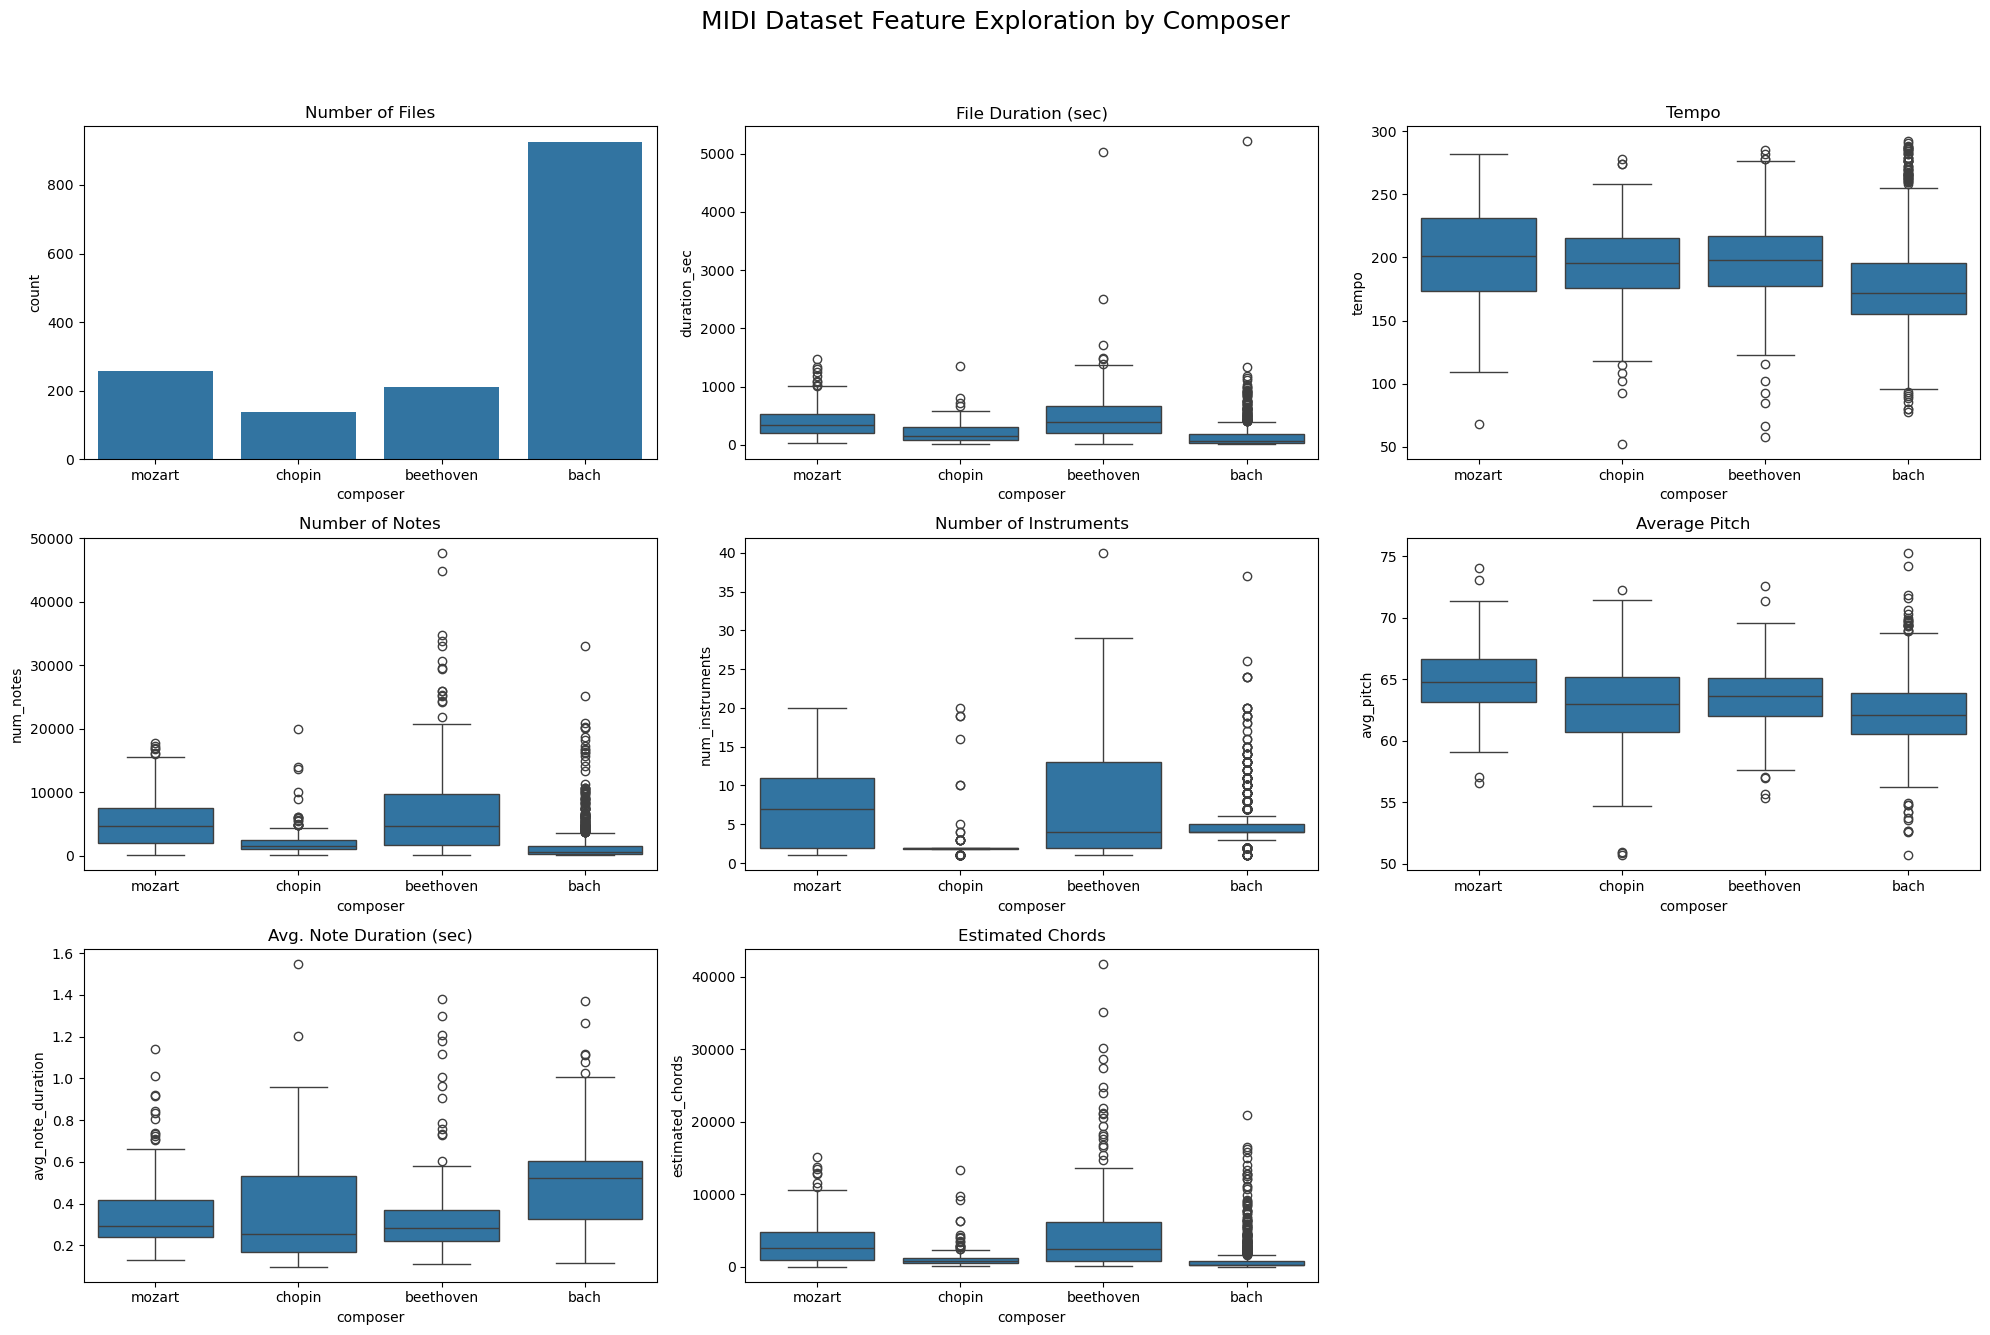

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(20, 14))  # set a 3x3 grid
fig.suptitle('MIDI Dataset Feature Exploration by Composer', fontsize=18)

# files per composer
sns.countplot(data=df, x='composer', ax=axes[0, 0])
axes[0, 0].set_title('Number of Files')

# duration
sns.boxplot(data=df, x='composer', y='duration_sec', ax=axes[0, 1])
axes[0, 1].set_title('File Duration (sec)')

# tempo
sns.boxplot(data=df, x='composer', y='tempo', ax=axes[0, 2])
axes[0, 2].set_title('Tempo')

# number of notes
sns.boxplot(data=df, x='composer', y='num_notes', ax=axes[1, 0])
axes[1, 0].set_title('Number of Notes')

# number of instruments
sns.boxplot(data=df, x='composer', y='num_instruments', ax=axes[1, 1])
axes[1, 1].set_title('Number of Instruments')

# average pitch
sns.boxplot(data=df, x='composer', y='avg_pitch', ax=axes[1, 2])
axes[1, 2].set_title('Average Pitch')

# average note duration
sns.boxplot(data=df, x='composer', y='avg_note_duration', ax=axes[2, 0])
axes[2, 0].set_title('Avg. Note Duration (sec)')

# estimated chords
sns.boxplot(data=df, x='composer', y='estimated_chords', ax=axes[2, 1])
axes[2, 1].set_title('Estimated Chords')

axes[2, 2].axis('off') # remove the last empty cell

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
# group the data by the composer column and calculate summary statistics
summary = df.groupby('composer').agg({
    'duration_sec': ['mean', 'std'], # average and standard deviation of song duration (in seconds)
    'tempo': ['mean', 'std'], # average and standard deviation of tempo (beats per minute)
    'num_notes': ['mean', 'std'], # average and standard deviation of the number of notes
    'num_instruments': ['mean', 'std'], # average and standard deviation of instruments used
    'avg_pitch': ['mean', 'std'], # average and standard deviation of pitch values
    'avg_note_duration': ['mean', 'std'], # average and standard deviation of note durations
    'estimated_chords': ['mean', 'std'] # average and standard deviation of estimated chords
})
summary

duration_sec                   tempo               num_notes  \
                  mean         std        mean        std         mean   
composer                                                                 
bach        151.615434  249.499357  177.165399  37.218228  1715.926486   
beethoven   508.257079  493.642193  196.775118  36.016860  7574.393365   
chopin      220.828000  184.496352  192.145840  37.234118  2350.757353   
mozart      400.837567  273.076911  200.196114  37.271395  5384.906250   

                       num_instruments            avg_pitch            \
                   std            mean       std       mean       std   
composer                                                                
bach       3130.736199        4.994595  3.355388  62.316620  2.877739   
beethoven  8364.785313        7.000000  7.242730  63.605638  2.554996   
chopin     2662.857948        2.448529  3.049760  62.883127  4.124341   
mozart     4136.806026        7.335938  5.063948  64.728388  2.596014   

          avg_note_duration           estimated_chords               
                       mean       std             mean          std  
composer                                                             
bach               0.484618  0.183333      1078.036757  2259.237361  
beethoven          0.337041  0.202577      5076.161137  6877.488262  
chopin             0.358941  0.253455      1302.536765  1790.901105  
mozart             0.347515  0.167855      3394.617188  3082.724569

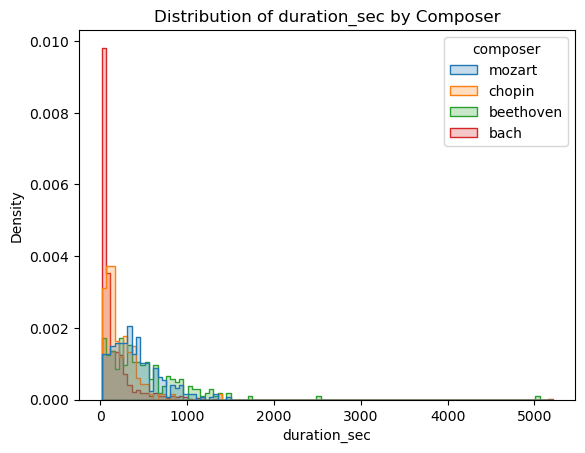

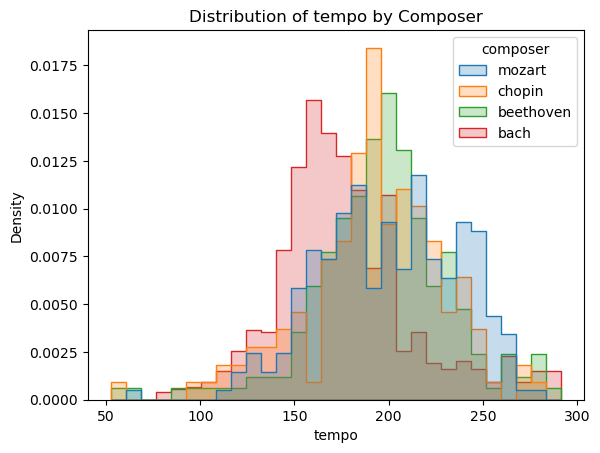

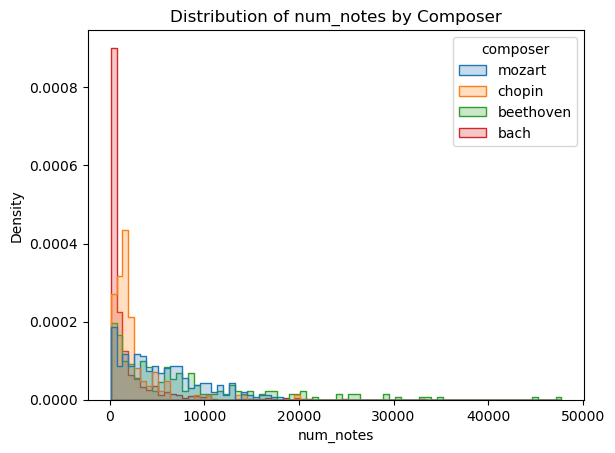

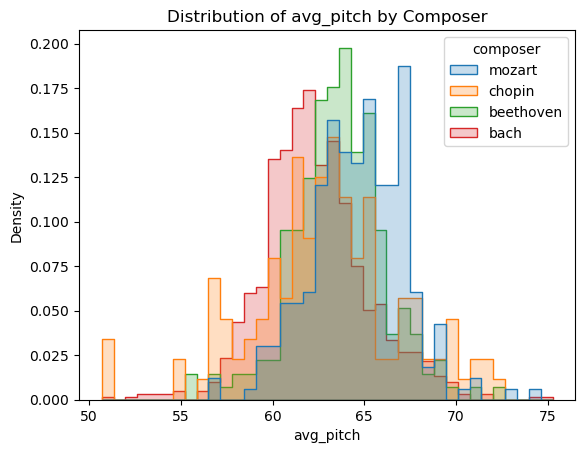

In [44]:
# features to visualize
features = ['duration_sec', 'tempo', 'num_notes', 'avg_pitch']

# for each feature 
for feat in features:
    # create a histogram with the distribution of the current feature
    sns.histplot(
        data=df, 
        x=feat, 
        hue='composer',           
        element='step',           
        stat='density',            
        common_norm=False          # avoid normalize across groups; keep each composer area independent
    )
    plt.title(f'Distribution of {feat} by Composer')
    plt.show()

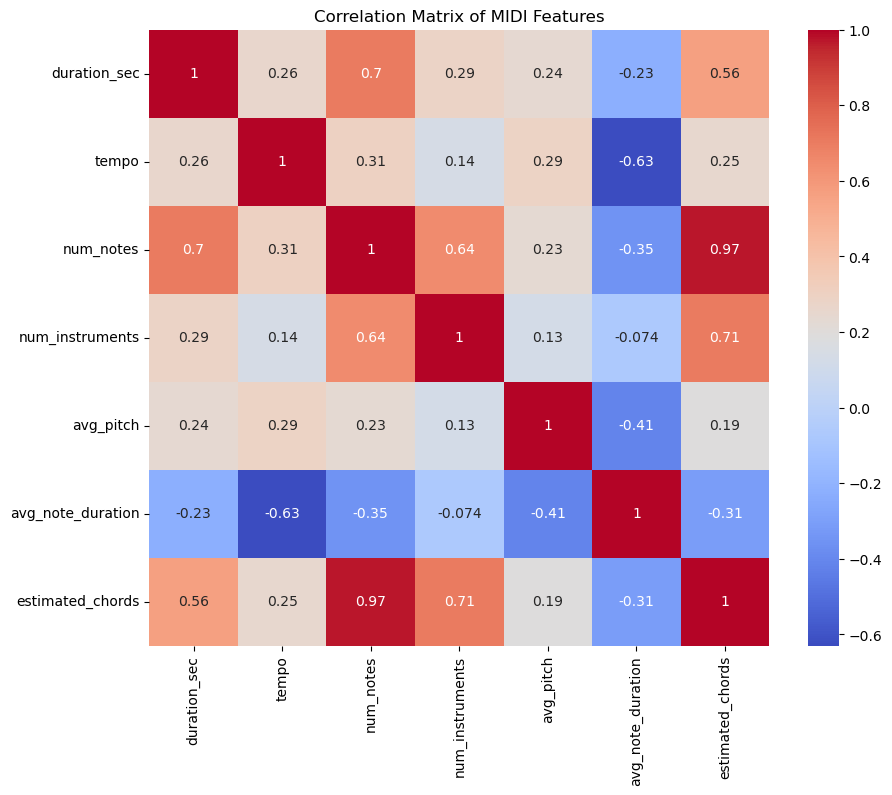

In [46]:
# get the correlation matrix of all numeric features
corr = df.drop(columns='composer').corr()
plt.figure(figsize=(10, 8)) # size

# create a heatmap to visualize the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')  
plt.title("Correlation Matrix of MIDI Features") 
plt.show()

## Model Building/Training: 
Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
Train the deep learning model using the pre-processed and feature-extracted data.


### Convolutional Neural Network (CNN)

In [48]:
# This function converts MIDI file into a fixed-size, normalized pianoroll representation so that it can be used as input to a CNN.
# We need to do this because CNNs expect fixed-size, grid-like input, similar to how images are represented as 2D arrays.

# fs = frames per second (temporal resolution)
# duration = max duration in seconds (pad/truncate for uniform shape)
def midi_to_pianoroll(midi, fs=10, duration=30):
    max_length = int(fs * duration)  # total frames
    piano_roll = midi.get_piano_roll(fs=fs)

    # clip to 128 MIDI pitches and max length
    roll = piano_roll[:128, :max_length]

    # pad if shorter than expected
    if roll.shape[1] < max_length:
        pad_width = max_length - roll.shape[1]
        roll = np.pad(roll, ((0, 0), (0, pad_width)), mode='constant')
    else:
        roll = roll[:, :max_length]

    return roll / 127.0  # normalize velocity values

In [52]:
# lists to hold input features and labels
X = []
y = []

# create a mapping from composer names to integer labels
label_map = {name: i for i, name in enumerate(sorted(df['composer'].unique()))}

# for each composer and midi pairs
for composer, midi in train_data:
    try:
        roll = midi_to_pianoroll(midi) # convert MIDI file to fixed-size pianoroll representation
        X.append(roll) # append the processed pianoroll 
        y.append(label_map[composer]) # append the corresponding label
    
    # catch and log any errors
    except Exception as e:
        print(f"Skipping file: {e}")

# convert lists to NumPy arrays for model input
X = np.array(X)
y = np.array(y)

# reshape input for CNN: add a channel dimension (grayscale image-like format)
X = X[..., np.newaxis] # final shape: (num_samples, 128 pitches, time steps, 1 channel)

In [55]:
# split 70% train, 15% val and 15% test
y_cat = to_categorical(y) # one-hot encode labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.3, random_state=42) # first 70% train and 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # then 15% test and 15% test

In [61]:
# build a CNN model
model_cnn = Sequential([

    # 1st convolutional layer (32 filters with 3x3 kernel size)
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, X.shape[2], 1)), 
    MaxPooling2D((2, 2)), # 1st max pooling layer to reduce spatial dimensions by taking max over 2x2 patches    
    Dropout(0.3), # randomly drops 30% of neurons during training to reduce overfitting

    # 2nd convolutional layer (64 filters with 3x3 kernel size)
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)), # 2nd max pooling layer
    Dropout(0.3), # dropout again

    Flatten(), # flatten the 2D feature maps to a 1D vector before passing to Dense layers

    # fully connected hidden layer with 128 neurons
    Dense(128, activation='relu'),
    Dropout(0.3), # dropout after dense layer

    Dense(len(label_map), activation='softmax') # output layer
])

# compile model
model_cnn.compile(optimizer='adam', # adaptive learning rate optimizer
                  loss='categorical_crossentropy', # categorical crossentropy loss function
                  metrics=['accuracy']) # use accuracy to evaluate

model_cnn.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 298, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 149, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 149, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 147, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 140160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    17,940,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,959,940 (68.51 MB)

 Trainable params: 17,959,940 (68.51 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# train the CNN model 
history_cnn = model_cnn.fit(
    X_train,            # training input data (pianoroll arrays)
    y_train,            # one-hot encoded training labels
    validation_data=(X_val, y_val),  # validation set for monitoring overfitting
    epochs=20,          # number of passes through the entire training set
    batch_size=32       # number of samples per training batch
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - accuracy: 0.5067 - loss: 1.3729 - val_accuracy: 0.6638 - val_loss: 0.9723
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step - accuracy: 0.6207 - loss: 0.8752 - val_accuracy: 0.6856 - val_loss: 0.7703
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.6825 - loss: 0.7468 - val_accuracy: 0.7118 - val_loss: 0.6706
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.8033 - loss: 0.5288 - val_accuracy: 0.7118 - val_loss: 0.7245
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.8641 - loss: 0.3564 - val_accuracy: 0.7467 - val_loss: 0.6136
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - accuracy: 0.9269 - loss: 0.2111 - val_accuracy: 0.7380 - val_loss: 0.6792
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.9769 - loss: 0.1020 - val_accuracy: 0.7467 - val_loss: 0.9446
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step - accuracy: 0.9663 - loss: 0.1420 - val_accu

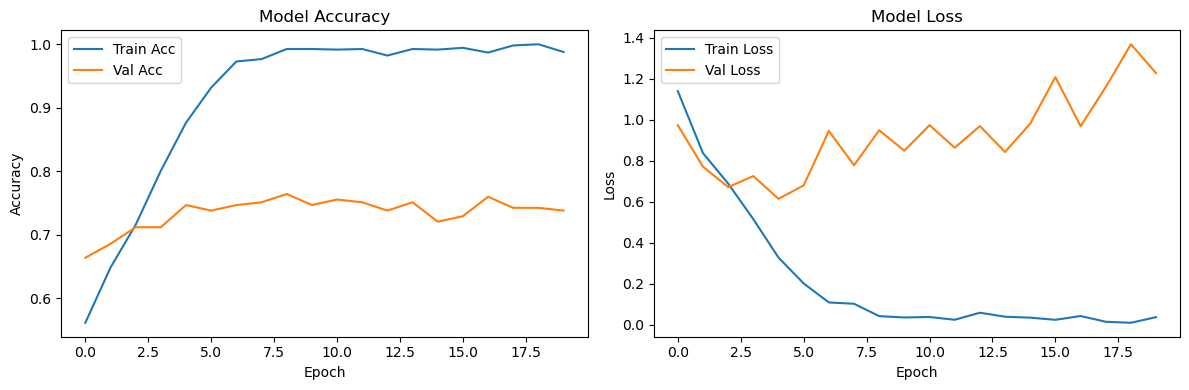

In [65]:
# plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### CNN Model Evaluation
Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.

In [67]:
# evaluate model on validation set
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy_cnn:.4f}")
print(f"Validation Loss: {loss_cnn:.4f}")

Validation Accuracy: 0.7380
Validation Loss: 1.2263


In [71]:
# convert one-hot back to label 
y_true_cnn = np.argmax(y_val, axis=1)
y_pred_cnn = np.argmax(model_cnn.predict(X_val), axis=1)

# decode numeric labels back to composer names
label_decoder_cnn = {v: k for k, v in label_map.items()}
target_names_cnn = [label_decoder_cnn[i] for i in range(len(label_decoder_cnn))]

# print precision, recall, f1-score
print(classification_report(y_true_cnn, y_pred_cnn, target_names=target_names_cnn))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
              precision    recall  f1-score   support

        bach       0.81      0.95      0.87       149
   beethoven       0.71      0.33      0.45        30
      chopin       0.67      0.26      0.38        23
      mozart       0.39      0.44      0.41        27

    accuracy                           0.74       229
   macro avg       0.64      0.50      0.53       229
weighted avg       0.73      0.74      0.71       229



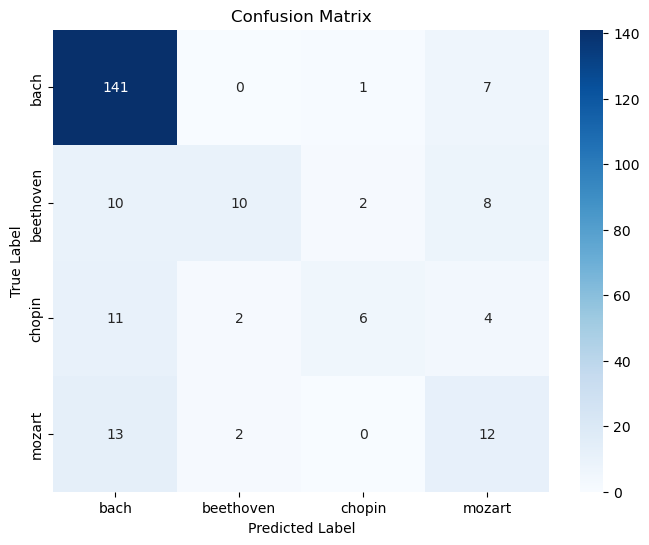

In [75]:
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn) # get confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_cnn,
            yticklabels=target_names_cnn)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Long Short-Term Memory (LSTM)

## Model Optimization: 
Optimize the deep learning model by fine-tuning hyperparameters.

**TODO**: Pick the best performer to further optimize hypermarameters

## Conclusion

----------------
$^{1}$ blanderbuss. (n.d.). MIDI classic music [Data set]. Kaggle. https://www.kaggle.com/datasets/blanderbuss/midi-classic-music